In [69]:
import pandas as pd
# Excelファイルを読み込む
df = pd.read_excel(r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\ver1_20250714.xlsx")
print(df.columns)

Index(['INDEX', '付属_1', 'Event', 'ASA', 'RBC Tx', 'FFP Tx', 'PLT Tx',
       'FluidBal', 'OpTime', 'Age', 'Male', 'BMI', 'Dialysis', 'Alb', 'BUN',
       'CRP', 'Cre', 'Hb', 'K', 'Na', 'PLT', 'T-Bil', 'WBC', 'CHF', 'Malig',
       'DeliMed', 'β-blocker', 'Oral steroids', 'Anticoag', 'Antiplatelet',
       'AntiCa', 'Opioid', 'Proc-Eye', 'Proc-Face/Neck', 'Proc-Thorax',
       'Proc-MSK', 'Proc-ENT', 'Proc-Neuro', 'Proc-Genital', 'Proc-Urinary',
       'Proc-Skin', 'Proc-Abd', 'ResectNum', 'HighRiskProc', 'HR at 6h',
       'MAP at 6h'],
      dtype='object')


In [70]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor

# --- 1. データ準備 ---
df = pd.read_excel(r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\ver1_20250714.xlsx")
idx_event = df[['INDEX', 'Event']]
df_values = df.drop(columns=['INDEX','Event','付属_1'])

# --- 2. LGBMRegressor を推定器に指定 ---
est_lgb = LGBMRegressor(
    n_estimators=50,      # 木の本数
    learning_rate=0.1,    # 学習率
    n_jobs=-1,            # 全コア並列
    random_state=0
)

imp = IterativeImputer(
    estimator=est_lgb,
    max_iter=5,           # イテレーション回数
    random_state=0,
    initial_strategy='mean'
)

# --- 3. 補完＋結合を一気に実行 ---
df_imputed = pd.concat([
    pd.DataFrame(
        imp.fit_transform(df_values),
        columns=df_values.columns,
        index=df.index
    ),
    idx_event
], axis=1)

# --- 4. 結果確認 ---
print(df_imputed.isna().sum())


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Number of data points in the train set: 30123, number of used features: 42
[LightGBM] [Info] Start training from score 2.050759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2815
[LightGBM] [Info] Number of data points in the train set: 30123, number of used features: 42
[LightGBM] [Info] Start training from score 0.148458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2818
[LightGBM] [Info] Number of data points in the train set: 30123, number of used features: 42
[LightGBM] [Info] Start tra

In [71]:
# 完全データセットをエクセルファイルに保存
df_imputed.to_excel('completed_data_20250714.xlsx', index=False)

In [72]:
import pandas as pd
completed_data = pd.read_excel(r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\completed_data_20250714.xlsx") 
print(completed_data.columns)

Index(['ASA', 'RBC Tx', 'FFP Tx', 'PLT Tx', 'FluidBal', 'OpTime', 'Age',
       'Male', 'BMI', 'Dialysis', 'Alb', 'BUN', 'CRP', 'Cre', 'Hb', 'K', 'Na',
       'PLT', 'T-Bil', 'WBC', 'CHF', 'Malig', 'DeliMed', 'β-blocker',
       'Oral steroids', 'Anticoag', 'Antiplatelet', 'AntiCa', 'Opioid',
       'Proc-Eye', 'Proc-Face/Neck', 'Proc-Thorax', 'Proc-MSK', 'Proc-ENT',
       'Proc-Neuro', 'Proc-Genital', 'Proc-Urinary', 'Proc-Skin', 'Proc-Abd',
       'ResectNum', 'HighRiskProc', 'HR at 6h', 'MAP at 6h', 'INDEX', 'Event',
       '付属_1'],
      dtype='object')


In [19]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# 1. ランダムシード
RANDOM_STATE = 42

# 2. completed_data のコピーと明示的 INDEX 列（すでにある場合はスキップ）
completed_data = completed_data.copy()
if "INDEX" not in completed_data.columns:
    completed_data["INDEX"] = completed_data.index

# 3. Stratified split を実施
train_df, holdout_df = train_test_split(
    completed_data,
    test_size=0.2,
    stratify=completed_data["Event"],
    random_state=RANDOM_STATE
)

# 4. INDEX による突合用データフレーム作成
split_info = pd.DataFrame({
    "INDEX": completed_data["INDEX"],
    "Set": np.where(completed_data["INDEX"].isin(train_df["INDEX"]), "Train", "Holdout")
})

# 5. completed_data に突合（マージ）
completed_data = completed_data.merge(split_info, on="INDEX", how="left")

# 6. 保存（任意）
completed_data.to_csv("completed_data_with_split.csv", index=False)

# 7. 結果確認（オプション）
print(completed_data["Set"].value_counts())


Set
Train      24098
Holdout     6025
Name: count, dtype: int64


In [ ]:
# -*- coding: utf-8 -*-
"""
Block 1: モデル開発・学習部分（修正・完全版）
 ─────────────────────────────────────────────
 ・不均衡対策：LogisticRegression(class_weight) / XGBoost・LightGBM(scale_pos_weight)
 ・3000 回ブートストラップ CI（AUROC / PR_AUC / Brier / CalSlope / CalInt）
 ・DeLong 法による AUROC 差の検定（ホールドアウト + 施設間：すべて術前LRを基準）
 ・CalibratedClassifierCV を用いた XGBoost/LGBM の事前校正
 ・最終的なメトリクス（summary_metrics.xlsx, all_facility_comparison.xlsx）を作成
 ・モデル保持用 Pickle / 予測確率 CSV も同時に出力
"""

import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from category_encoders import TargetEncoder

import optuna
import xgboost as xgb
import lightgbm as lgb

import pickle
import scipy.stats as _st

warnings.filterwarnings("ignore", category=FutureWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# -------------------------------------------------- #
# （1）グローバル設定
# -------------------------------------------------- #
RANDOM_STATE   = 42
N_SPLITS_OUTER = 5      # 外部CV（性能評価用）
N_SPLITS_TUNE  = 5      # ハイパラチューニング用CV
N_TRIALS       = 100    # Optuna 探索回数（時間短縮のため100に設定。必要に応じて増減）
N_BOOTSTRAP    = 1000   # ブートストラップ回数（時間短縮のため1000に設定）

# 結果出力ディレクトリ
RESULTS_DIR = Path("results_" + datetime.now().strftime("%Y%m%d_%H%M"))
RESULTS_DIR.mkdir(exist_ok=True)
np.random.seed(RANDOM_STATE)

# -------------------------------------------------- #
# （2）カスタム Transformer：Winsorize + log1p
# -------------------------------------------------- #
class WinsorizeLog1pTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, p_low=.005, p_high=.995, skew_thr=1.0):
        self.p_low = p_low
        self.p_high = p_high
        self.skew_thr = skew_thr

    def fit(self, X, y=None):
        df = pd.DataFrame(X).astype(float)
        self.q_ = {c: df[c].quantile([self.p_low, self.p_high]).values for c in df}
        self.logmask_ = {c: (df[c] >= 0).all() and abs(df[c].skew()) > self.skew_thr for c in df}
        return self

    def transform(self, X):
        df = pd.DataFrame(X).astype(float).copy()
        for c in df:
            lo, hi = self.q_[c]
            df[c] = df[c].clip(lo, hi)
            if self.logmask_[c]:
                df[c] = np.log1p(df[c])
        return df.values

# -------------------------------------------------- #
# （3）GPU 使用フラグ
# -------------------------------------------------- #
def xgb_gpu_params():
    try:
        xgb.XGBClassifier(tree_method='gpu_hist')
        return {"tree_method": "gpu_hist", "predictor": "gpu_predictor"}
    except Exception:
        return {"tree_method": "hist", "predictor": "auto"}

def lgb_gpu_flag():
    try:
        lgb.LGBMClassifier(device='gpu')
        return {"device": "gpu"}
    except Exception:
        return {}

# -------------------------------------------------- #
# （4）DeLong 法による AUROC 検定関数
# -------------------------------------------------- #
def _compute_midrank(x):
    J, Z, N = np.argsort(x), x[np.argsort(x)], len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5 * (i + j - 1)
        i = j
    T2 = np.empty(N, dtype=float)
    T2[J] = T + 1
    return T2

def _fast_delong(preds_sorted_transposed, label_1_count):
    m = label_1_count
    n = preds_sorted_transposed.shape[1] - m
    k = preds_sorted_transposed.shape[0]
    tx = np.zeros((k, m))
    ty = np.zeros((k, n))
    for r in range(k):
        x = preds_sorted_transposed[r, :m]
        y = preds_sorted_transposed[r, m:]
        tx[r, :] = _compute_midrank(np.r_[x, y])[:m]
        ty[r, :] = _compute_midrank(np.r_[x, y])[m:]
    aucs = (tx.sum(axis=1) - m * (m + 1) / 2) / (m * n)
    v01 = (tx - tx.mean(axis=1, keepdims=True)) / n
    v10 = 1.0 - (ty - ty.mean(axis=1, keepdims=True)) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    S = sx / m + sy / n
    return aucs, S

def delong_roc_test(y_true, y_pred1, y_pred2):
    y_true, y_pred1, y_pred2 = np.asarray(y_true), np.asarray(y_pred1), np.asarray(y_pred2)
    label_1_count = int(np.sum(y_true == 1))
    order = np.argsort(-y_pred1)
    y_pred1_sorted, y_pred2_sorted, y_true_sorted = y_pred1[order], y_pred2[order], y_true[order]

    pos_idx = np.where(y_true_sorted == 1)[0]
    neg_idx = np.where(y_true_sorted == 0)[0]

    p1_sorted = np.concatenate([y_pred1_sorted[pos_idx], y_pred1_sorted[neg_idx]])
    p2_sorted = np.concatenate([y_pred2_sorted[pos_idx], y_pred2_sorted[neg_idx]])

    aucs, cov = _fast_delong(np.vstack([p1_sorted, p2_sorted]), label_1_count)
    diff = aucs[1] - aucs[0]
    var = cov[0,0] + cov[1,1] - 2 * cov[0,1]
    z = np.abs(diff) / np.sqrt(var) if var > 0 else np.inf
    pval = 2 * (1 - _st.norm.cdf(z))
    return aucs[0], aucs[1], pval

# -------------------------------------------------- #
# （5）Helper 関数: メトリクス計算とブートストラップCI
# -------------------------------------------------- #
def calib_slope_int(y, p):
    eps = 1e-15
    p_clipped = np.clip(p, eps, 1 - eps)
    logit = np.log(p_clipped / (1 - p_clipped))
    lr = LogisticRegression(solver="lbfgs", random_state=RANDOM_STATE).fit(logit.reshape(-1, 1), y)
    return lr.coef_[0][0], lr.intercept_[0]

def _metric_set(y_true, y_pred):
    auroc = roc_auc_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)
    brier = brier_score_loss(y_true, y_pred)
    slope, inter = calib_slope_int(y_true, y_pred)
    return auroc, pr_auc, brier, slope, inter

def bootstrap_ci(y_true, y_pred, n_boot=N_BOOTSTRAP, seed=RANDOM_STATE, alpha=.05):
    rng, idx = np.random.RandomState(seed), np.arange(len(y_true))
    # Ensure y_true and y_pred are numpy arrays for efficient indexing
    y_true_np, y_pred_np = np.asarray(y_true), np.asarray(y_pred)
    
    boot_indices = rng.choice(idx, size=(n_boot, len(idx)), replace=True)
    stats = np.array([_metric_set(y_true_np[samp], y_pred_np[samp]) for samp in boot_indices])
    point_estimates = _metric_set(y_true_np, y_pred_np)
    
    lo = np.percentile(stats, 100 * alpha / 2, axis=0)
    hi = np.percentile(stats, 100 * (1 - alpha / 2), axis=0)

    keys = ["AUROC", "PR_AUC", "Brier", "CalSlope", "CalInt"]
    return {keys[i]: (point_estimates[i], lo[i], hi[i]) for i in range(len(keys))}

# -------------------------------------------------- #
# （6）Estimator & Pipeline の構築
# -------------------------------------------------- #
def build_estimator(name, pos_w):
    if name == "Logistic":
        mdl = LogisticRegression(penalty="l2", solver="liblinear", max_iter=1000, random_state=RANDOM_STATE)
        space = {
            "model__C": optuna.distributions.FloatDistribution(1e-3, 1e1, log=True),
            "model__class_weight": optuna.distributions.CategoricalDistribution([None, "balanced"])
        }
    elif name == "XGBoost":
        low, high = max(1e-3, .5 * pos_w), 1.5 * pos_w
        mdl = xgb.XGBClassifier(objective="binary:logistic", eval_metric="aucpr", n_estimators=500, random_state=RANDOM_STATE, **xgb_gpu_params())
        space = {
            "model__max_depth": optuna.distributions.IntDistribution(3, 7),
            "model__learning_rate": optuna.distributions.FloatDistribution(1e-3, 3e-2, log=True),
            "model__subsample": optuna.distributions.FloatDistribution(.6, .9),
            "model__colsample_bytree": optuna.distributions.FloatDistribution(.6, .9),
            "model__reg_alpha": optuna.distributions.FloatDistribution(1e-2, 10, log=True),
            "model__reg_lambda": optuna.distributions.FloatDistribution(1e-2, 10, log=True),
            "model__scale_pos_weight": optuna.distributions.FloatDistribution(low, high)
        }
    else:  # LightGBM
        low, high = max(1e-3, .5 * pos_w), 1.5 * pos_w
        mdl = lgb.LGBMClassifier(objective="binary", metric="aucpr", n_estimators=500, random_state=RANDOM_STATE, **lgb_gpu_flag())
        space = {
            "model__num_leaves": optuna.distributions.IntDistribution(31, 127),
            "model__max_depth": optuna.distributions.IntDistribution(5, 15),
            "model__learning_rate": optuna.distributions.FloatDistribution(1e-3, 3e-2, log=True),
            "model__feature_fraction": optuna.distributions.FloatDistribution(.6, .9),
            "model__bagging_fraction": optuna.distributions.FloatDistribution(.6, .9),
            "model__bagging_freq": optuna.distributions.IntDistribution(1, 5),
            "model__lambda_l1": optuna.distributions.FloatDistribution(1e-3, 10, log=True),
            "model__lambda_l2": optuna.distributions.FloatDistribution(1e-3, 10, log=True),
            "model__scale_pos_weight": optuna.distributions.FloatDistribution(low, high)
        }
    return mdl, space

def build_pipe(model, cat_cols, num_cols):
    num_pipe = Pipeline([
        ("winsorlog", WinsorizeLog1pTransformer()),
        ("imp", SimpleImputer(strategy="median")),
        ("scl", RobustScaler())
    ])
    pre = ColumnTransformer([
        ("cat", TargetEncoder(handle_unknown="value", handle_missing="value"), cat_cols),
        ("num", num_pipe, num_cols)
    ], remainder="drop") # 使用しない列はここで除外
    return Pipeline([("pre", pre), ("model", model)])

# -------------------------------------------------- #
# （7）Optuna チューニング用関数 (修正版)
# -------------------------------------------------- #
def tune(pipe, space, X, y):
    """
    Optunaの `Trial` オブジェクトのAPI変更に対応したバージョン。
    trial.suggest() の代わりに、型別の suggest_float, suggest_int, suggest_categorical を使用。
    """
    def objective(trial):
        # パラメータの提案方法をOptuna v3以降のAPIに修正
        params = {}
        for name, distribution in space.items():
            if isinstance(distribution, optuna.distributions.FloatDistribution):
                params[name] = trial.suggest_float(
                    name=name,
                    low=distribution.low,
                    high=distribution.high,
                    log=distribution.log,
                )
            elif isinstance(distribution, optuna.distributions.IntDistribution):
                params[name] = trial.suggest_int(
                    name=name,
                    low=distribution.low,
                    high=distribution.high,
                    step=distribution.step,
                )
            elif isinstance(distribution, optuna.distributions.CategoricalDistribution):
                params[name] = trial.suggest_categorical(
                    name=name,
                    choices=distribution.choices,
                )

        pipe.set_params(**params)
        cv = StratifiedKFold(n_splits=N_SPLITS_TUNE, shuffle=True, random_state=RANDOM_STATE)
        preds = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
        return average_precision_score(y, preds)

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)

    best_params = study.best_params
    pipe.set_params(**best_params)
    
    # Optunaのパラメータ名から 'model__' プレフィックスを削除して返す
    cleaned_best_params = {k.replace('model__', ''): v for k, v in best_params.items()}
    return pipe, cleaned_best_params

# -------------------------------------------------- #
# （8）実験統括関数
# -------------------------------------------------- #
def experiment_metrics(model_name, X_dev, y_dev, X_hold, y_hold, cat_cols, num_cols):
    """チューニング、学習、ホールドアウト評価の一連の処理を行う"""
    pos_w = (y_dev == 0).sum() / (y_dev == 1).sum() if (y_dev == 1).sum() > 0 else 1
    base_model, space = build_estimator(model_name, pos_w)
    
    pipe = build_pipe(base_model, cat_cols, num_cols)
    tuned_pipe, best_hparams = tune(pipe, space, X_dev, y_dev)
    
    if model_name in ["XGBoost", "LightGBM"]:
        final_model = CalibratedClassifierCV(estimator=tuned_pipe, method="isotonic", cv=N_SPLITS_TUNE)
    else:
        final_model = tuned_pipe
    
    final_model.fit(X_dev, y_dev)

    pred_hold = final_model.predict_proba(X_hold)[:, 1]
    hold_metrics_with_ci = bootstrap_ci(y_hold.values, pred_hold)
    
    formatted_metrics = {}
    for k, (pnt, lo, hi) in hold_metrics_with_ci.items():
        formatted_metrics[k] = pnt
        formatted_metrics[f"{k}_lo"] = lo
        formatted_metrics[f"{k}_hi"] = hi

    return pred_hold, formatted_metrics, final_model, best_hparams

def calculate_cv_metrics(model_name, X, y, cat_cols, num_cols):
    """交差検証(CV)によるメトリクスを計算"""
    pos_w = (y == 0).sum() / (y == 1).sum() if (y == 1).sum() > 0 else 1
    base, space = build_estimator(model_name, pos_w)
    pipe = build_pipe(base, cat_cols, num_cols)
    tuned_pipe, _ = tune(pipe, space, X, y)

    if model_name in ["XGBoost", "LightGBM"]:
        eval_model = CalibratedClassifierCV(estimator=tuned_pipe, method="isotonic", cv=N_SPLITS_TUNE)
    else:
        eval_model = tuned_pipe
    
    skf = StratifiedKFold(n_splits=N_SPLITS_OUTER, shuffle=True, random_state=RANDOM_STATE)
    cv_preds = cross_val_predict(eval_model, X, y, cv=skf, method="predict_proba", n_jobs=-1)[:, 1]
    
    cv_metrics_with_ci = bootstrap_ci(y.values, cv_preds)
    
    formatted_metrics = {}
    for k, (pnt, lo, hi) in cv_metrics_with_ci.items():
        formatted_metrics[k] = pnt
        formatted_metrics[f"{k}_lo"] = lo
        formatted_metrics[f"{k}_hi"] = hi
        
    return formatted_metrics

# -------------------------------------------------- #
# （9）Main loop：学習＋CV/Hold-out/施設間→メトリクス・CSV/Excel 保存
# -------------------------------------------------- #
if __name__ == "__main__":
    
    # -------------------------------------------------- #
    # （★）ご自身のデータ読み込みと変数定義に差し替え
    # -------------------------------------------------- #
    DATA_PATH = r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\completed_data_20250714.xlsx"
    DF = pd.read_excel(DATA_PATH)
    DF["付属_1"] = DF["付属_1"].astype(int)

    CAT_PRE  = ["Male",'Dialysis', 'CHF', 'Malig', 'β-blocker','Oral steroids',
                'DeliMed', 'Anticoag', 'Antiplatelet', 'AntiCa', 'Opioid', 'Proc-Eye',
                'Proc-Face/Neck', 'Proc-Thorax', 'Proc-MSK', 'Proc-ENT', 'Proc-Neuro',
                'Proc-Genital', 'Proc-Urinary', 'Proc-Skin', 'Proc-Abd', 'ResectNum',
                'HighRiskProc']
    NUM_PRE  = ['ASA','Age', 'BMI','Alb', 'BUN', 'CRP', 'Cre', 'Hb', 'K', 'Na',
                'PLT', 'T-Bil', 'WBC']

    CAT_INTRA = CAT_PRE.copy()
    NUM_INTRA = NUM_PRE + ['RBC Tx', 'FFP Tx', 'PLT Tx', 'FluidBal','OpTime','HR at 6h', 'MAP at 6h']

    VARIANTS = {
        "①Pre-op":    (CAT_PRE, NUM_PRE),
        "②Pre+Intra": (CAT_INTRA, NUM_INTRA)
    }
    # -------------------------------------------------- #

    summary = []
    facility_results = []
    all_hyperparams = []

    for variant in VARIANTS:
        print(f"--- Processing Variant: {variant} ---")
        CAT_COLS, NUM_COLS = VARIANTS[variant]

        dev, hold = train_test_split(DF, test_size=0.2, stratify=DF["Event"], random_state=RANDOM_STATE)
        X_dev, y_dev = dev.drop(columns=["Event"]), dev["Event"]
        X_hold, y_hold = hold.drop(columns=["Event"]), hold["Event"]

        all_preds_hold = {}
        all_models_hold = {}

        for model_name in ["Logistic", "XGBoost", "LightGBM"]:
            print(f"  - Training Model: {model_name}")
            
            pred_hold, hold_metrics, model_hold, hparams = experiment_metrics(
                model_name, X_dev, y_dev, X_hold, y_hold, CAT_COLS, NUM_COLS
            )
            all_preds_hold[model_name] = pred_hold
            all_models_hold[model_name] = model_hold

            cv_metrics = calculate_cv_metrics(model_name, X_dev, y_dev, CAT_COLS, NUM_COLS)

            if model_name == "Logistic":
                p_hold, diff_hold = 0.0, 0.0
            else:
                _, _, p_hold = delong_roc_test(y_hold.values, all_preds_hold["Logistic"], pred_hold)
                diff_hold = roc_auc_score(y_hold, pred_hold) - roc_auc_score(y_hold, all_preds_hold["Logistic"])
            
            summary.append({
                "Variant": variant, "Model": model_name,
                **{f"CV_{k}": v for k, v in cv_metrics.items()},
                **{f"Hold_{k}": v for k, v in hold_metrics.items()},
                "Hold_p_vs_Pre": p_hold, "Hold_AUROC_diff": diff_hold
            })
            all_hyperparams.append({"Variant": variant, "Model": model_name, **hparams})

            with open(RESULTS_DIR / f"{variant}_{model_name}_hold_model.pkl", "wb") as f:
                pickle.dump(model_hold, f)
            
            pd.DataFrame({
                "Index": X_hold.index, "y_true": y_hold.values, "y_pred": pred_hold
            }).to_csv(RESULTS_DIR / f"{variant}_{model_name}_hold_preds.csv", index=False)

    print("\n--- Processing Inter-Facility Comparison ---")
    for variant in VARIANTS:
        CAT_COLS, NUM_COLS = VARIANTS[variant]
        for tr, te in [(0, 1), (1, 0)]:
            train_fac_df = DF[DF["付属_1"] == tr]
            test_fac_df = DF[DF["付属_1"] == te]

            if len(test_fac_df) < 50 or len(train_fac_df) < 50:
                print(f"  - Skipping {tr} -> {te} due to insufficient data.")
                continue

            print(f"  - Comparing facilities: Train on {tr}, Test on {te}")
            X_train_fac, y_train_fac = train_fac_df.drop(columns=["Event"]), train_fac_df["Event"]
            X_test_fac, y_test_fac = test_fac_df.drop(columns=["Event"]), test_fac_df["Event"]

            preds_fac = {}
            for model_name in ["Logistic", "XGBoost", "LightGBM"]:
                _, _, model_fac, _ = experiment_metrics(
                    model_name, X_train_fac, y_train_fac, X_test_fac, y_test_fac, CAT_COLS, NUM_COLS
                )
                preds_fac[model_name] = model_fac.predict_proba(X_test_fac)[:, 1]

            for model_name, pred_fac in preds_fac.items():
                metrics_fac_ci = bootstrap_ci(y_test_fac.values, pred_fac)
                
                if model_name == "Logistic":
                    p_fac, diff_fac = 0.0, 0.0
                else:
                    _, _, p_fac = delong_roc_test(y_test_fac.values, preds_fac["Logistic"], pred_fac)
                    diff_fac = roc_auc_score(y_test_fac, pred_fac) - roc_auc_score(y_test_fac, preds_fac["Logistic"])
                
                res = {"Variant": variant, "Model": model_name, "From→To": f"{tr}→{te}"}
                for k, (pnt, lo, hi) in metrics_fac_ci.items():
                    res[k], res[f"{k}_lo"], res[f"{k}_hi"] = pnt, lo, hi
                res.update({"p_vs_Pre": p_fac, "AUROC_diff": diff_fac})
                facility_results.append(res)

    df_summary = pd.DataFrame(summary)
    df_summary.to_excel(RESULTS_DIR / "summary_metrics.xlsx", index=False, float_format="%.4f")
    print(f"\nFinished → {RESULTS_DIR / 'summary_metrics.xlsx'}")

    if facility_results:
        df_fac = pd.DataFrame(facility_results)
        for metric in ["AUROC", "PR_AUC", "Brier", "CalSlope", "CalInt"]:
            df_fac[f"{metric}_CI"] = df_fac.apply(
                lambda r: f"{r[f'{metric}_lo']:.3f}-{r[f'{metric}_hi']:.3f}" if pd.notna(r.get(f'{metric}_lo')) else "",
                axis=1
            )
        drop_cols = [c for c in df_fac.columns if '_lo' in str(c) or '_hi' in str(c)]
        df_fac = df_fac.drop(columns=drop_cols)
        df_fac.to_excel(RESULTS_DIR / "all_facility_comparison.xlsx", index=False, float_format="%.4f")
        print(f"Finished → {RESULTS_DIR / 'all_facility_comparison.xlsx'}")

    df_hyperparams = pd.DataFrame(all_hyperparams)
    hparam_cols = sorted([col for col in df_hyperparams.columns if col not in ['Variant', 'Model']])
    df_hyperparams = df_hyperparams[['Variant', 'Model'] + hparam_cols]
    df_hyperparams.to_excel(RESULTS_DIR / "selected_hyperparameters.xlsx", index=False)
    print(f"Finished → {RESULTS_DIR / 'selected_hyperparameters.xlsx'}")

--- Processing Variant: ①Pre-op ---
  - Training Model: Logistic
  - Training Model: XGBoost


c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\xgboost\core.py:2676: UserWarning: [11:16:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  i

c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\xgboost\core.py:2676: UserWarning: [11:16:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predict

c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\xgboost\core.py:2676: UserWarning: [11:16:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predict

c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\xgboost\core.py:2676: UserWarning: [11:16:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predict

c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\xgboost\core.py:2676: UserWarning: [11:16:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


  - Training Model: LightGBM
[LightGBM] [Warning] feature_fraction is set=0.8322860137507747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322860137507747
[LightGBM] [Warning] lambda_l1 is set=0.008041989177193504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008041989177193504
[LightGBM] [Warning] lambda_l2 is set=0.001473136193881541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001473136193881541
[LightGBM] [Warning] bagging_fraction is set=0.8215169060290004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215169060290004
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8322860137507747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322860137507747
[LightGBM] [Warning] lambda_l1 is set=0.008041989177193504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008041989177193

c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 指定されたファイルが見つかりません。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\tears\anaconda3\envs\py311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tears\anaconda3\envs\py311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\tears\anaconda3\envs\py311\Lib\subprocess.py", line 1538, in _execute_child
    hp, 

[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (0.29 MB) transferred to GPU in 0.001559 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110904 -> initscore=-2.081544
[LightGBM] [Info] Start training from score -2.081544
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (0.24 MB) transferred to GPU in 0.001627 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (0.24 MB) transferred to GPU in 0.001504 secs. 1 sparse feature groups
[LightGBM] [Warning] No f

c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8322860137507747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322860137507747
[LightGBM] [Warning] lambda_l1 is set=0.008041989177193504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008041989177193504
[LightGBM] [Warning] lambda_l2 is set=0.001473136193881541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001473136193881541
[LightGBM] [Warning] bagging_fraction is set=0.8215169060290004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215169060290004
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8322860137507747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322860137507747
[LightGBM] [Warning] lambda_l1 is set=0.008041989177193504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008041989177193504
[LightGBM] [Warning] lamb

c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8322860137507747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322860137507747
[LightGBM] [Warning] lambda_l1 is set=0.008041989177193504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008041989177193504
[LightGBM] [Warning] lambda_l2 is set=0.001473136193881541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001473136193881541
[LightGBM] [Warning] bagging_fraction is set=0.8215169060290004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215169060290004
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8322860137507747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322860137507747
[LightGBM] [Warning] lambda_l1 is set=0.008041989177193504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008041989177193504
[LightGBM] [Warning] lamb

c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8322860137507747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322860137507747
[LightGBM] [Warning] lambda_l1 is set=0.008041989177193504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008041989177193504
[LightGBM] [Warning] lambda_l2 is set=0.001473136193881541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001473136193881541
[LightGBM] [Warning] bagging_fraction is set=0.8215169060290004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215169060290004
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8322860137507747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322860137507747
[LightGBM] [Warning] lambda_l1 is set=0.008041989177193504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008041989177193504
[LightGBM] [Warning] lamb

c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8322860137507747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322860137507747
[LightGBM] [Warning] lambda_l1 is set=0.008041989177193504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008041989177193504
[LightGBM] [Warning] lambda_l2 is set=0.001473136193881541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001473136193881541
[LightGBM] [Warning] bagging_fraction is set=0.8215169060290004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215169060290004
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8322860137507747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322860137507747
[LightGBM] [Warning] lambda_l1 is set=0.008041989177193504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008041989177193504
[LightGBM] [Warning] lamb

c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\tears\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam

[LightGBM] [Warning] feature_fraction is set=0.8322860137507747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322860137507747
[LightGBM] [Warning] lambda_l1 is set=0.008041989177193504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008041989177193504
[LightGBM] [Warning] lambda_l2 is set=0.001473136193881541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001473136193881541
[LightGBM] [Warning] bagging_fraction is set=0.8215169060290004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215169060290004
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8322860137507747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322860137507747
[LightGBM] [Warning] lambda_l1 is set=0.008041989177193504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008041989177193504
[LightGBM] [Warning] lamb

In [41]:
# -*- coding: utf-8 -*-
"""
Block 2: Model evaluation & Figure generation + Decision Curve Analysis (DCA) + Decision Threshold Table
- Load Pickle models & CSVs (hold_preds, ext_preds) from Block 1 results
- Plot combined Hold-out ROC/PR/Calibration for all 6 models in a single figure (legends inside)
- Plot combined Decision Curve Analysis (DCA) for all 6 models
- Generate Decision Threshold Table (sensitivity, specificity, PPV, NPV, net benefit) across thresholds
- English labels for manuscript figures
"""
import os
import glob
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
# Increase overall font size for readability
plt.rcParams.update({'font.size': 14})
warnings.filterwarnings("ignore", category=FutureWarning)

# -------------------------------------------------- #
# (1) Locate latest results folder containing summary_metrics.xlsx
# -------------------------------------------------- #
candidate_dirs = [d for d in glob.glob("results_*") if os.path.isdir(d) and (Path(d)/"summary_metrics.xlsx").exists()]
if not candidate_dirs:
    raise FileNotFoundError("Cannot find results_YYYYMMDD_HHMM folder with summary_metrics.xlsx.")
RESULTS_DIR = Path(sorted(candidate_dirs)[-1])
print(f"Using results from: {RESULTS_DIR}")

# -------------------------------------------------- #
# (2) Definitions
# -------------------------------------------------- #
VARIANTS = ["①Pre-op", "②Pre+Intra"]
MODELS   = ["Logistic", "XGBoost", "LightGBM"]

# Load summary for CI
df_summary = pd.read_excel(RESULTS_DIR/"summary_metrics.xlsx")
ci_dict = {v:{} for v in VARIANTS}
for v in VARIANTS:
    sub = df_summary[df_summary['Variant']==v]
    for m in MODELS:
        row = sub[sub['Model']==m]
        if row.empty: continue
        ci_dict[v][m] = {
            'AUROC':(row['Hold_AUROC_lo'].item(), row['Hold_AUROC_hi'].item()),
            'PR_AUC':(row['Hold_PR_AUC_lo'].item(), row['Hold_PR_AUC_hi'].item())
        }

def format_ci(metric, variant, model_name):
    lo, hi = ci_dict[variant][model_name][metric]
    return f"({lo:.3f}–{hi:.3f})"

def find_hold_csv(variant, model_name):
    if model_name == "Logistic":
        fname = f"{variant}_Logistic_preop_hold_preds.csv"
    else:
        fname = f"{variant}_{model_name}_hold_preds.csv"
    path = RESULTS_DIR/fname
    return path if path.exists() else None

# -------------------------------------------------- #
# -------------------------------------------------- #
# (3) Plot combined ROC curves (legend only model names, no AUC numbers)
# -------------------------------------------------- #
def plot_all_models_combined_roc():
    fig, ax = plt.subplots(figsize=(8,7))
    # Plot ROC for each model with only model names in legend
    for v in VARIANTS:
        for m in MODELS:
            csv = find_hold_csv(v,m)
            if not csv:
                continue
            df = pd.read_csv(csv)
            # Suppress auto label and manually set label
            disp = RocCurveDisplay.from_predictions(
                df['y_true'], df['y_pred'], ax=ax, name=None
            )
            disp.line_.set_label(f"{v}/{m}")
    # Plot diagonal reference line
    ax.plot([0,1], [0,1], '--', color='black', label='Random')
    ax.set_title('Hold-out ROAUC Curves of All Models')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    # Legend inside lower right with only model names and Random
    ax.legend(loc='lower right', fontsize='small')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR/'AllModels_ROC.png', dpi=300, bbox_inches='tight')
    plt.close()

# -------------------------------------------------- #
# (4) Plot combined Precision-Recall curves (legend no numbers, font medium)
# -------------------------------------------------- #
def plot_all_models_combined_pr():
    fig, ax = plt.subplots(figsize=(8,7))
    for v in VARIANTS:
        for m in MODELS:
            csv = find_hold_csv(v,m)
            if not csv: continue
            df = pd.read_csv(csv)
            prec, rec, _ = precision_recall_curve(df['y_true'], df['y_pred'])
            # Plot PR with only variant/model labels
            PrecisionRecallDisplay(precision=prec, recall=rec).plot(ax=ax, name=f"{v}/{m}")
    ax.set_title('Hold-out Precision-Recall Curves of All Models')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    # Legend inside lower-left
    ax.legend(loc='upper right', fontsize='small')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR/'AllModels_PR.png', dpi=300, bbox_inches='tight')
    plt.close()

# -------------------------------------------------- #
# (5) Plot combined Calibration curves (legend font medium)
# -------------------------------------------------- #
def plot_all_models_combined_calibration():
    fig, ax = plt.subplots(figsize=(7,7))
    for v in VARIANTS:
        for m in MODELS:
            csv = find_hold_csv(v,m)
            if not csv: continue
            df = pd.read_csv(csv)
            prob_true, prob_pred = calibration_curve(df['y_true'], df['y_pred'], n_bins=10)
            ax.plot(prob_pred, prob_true, marker='o', label=f"{v}/{m}")
    ax.plot([0,1],[0,1],'--', color='gray', label='Ideal')
    ax.set_title('Hold-out Calibration Curves of All Models')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Observed Proportion')
    ax.legend(loc='lower right', fontsize='medium')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR/'AllModels_Calibration.png', dpi=300, bbox_inches='tight')
    plt.close()

# -------------------------------------------------- #
# (6) Decision Curve Analysis (DCA)
# -------------------------------------------------- #
def net_benefit(y_true, y_pred, threshold):
    y_hat = (y_pred >= threshold).astype(int)
    tp = ((y_true==1)&(y_hat==1)).sum()
    fp = ((y_true==0)&(y_hat==1)).sum()
    n  = len(y_true)
    return tp/n - fp/n*(threshold/(1-threshold))

def plot_all_models_combined_dca():
    fig, ax = plt.subplots(figsize=(8,7))
    # Reference lines
    log_csv = find_hold_csv('①Pre-op','Logistic')
    df_log = pd.read_csv(log_csv)
    prev = df_log['y_true'].mean()
    thr = np.linspace(0.01,0.99,99)
    # No intervention and Treat All lines
    ax.plot(thr, np.zeros_like(thr), '--', color='gray', label='No Intervention')
    treatall_nb = prev - (1-prev)*(thr/(1-thr))
    ax.plot(thr, treatall_nb, '--', color='black', label='Treat All')

    # Model net benefit curves
    for v in VARIANTS:
        for m in MODELS:
            csv = find_hold_csv(v,m)
            if not csv: continue
            df = pd.read_csv(csv)
            nb = [net_benefit(df['y_true'], df['y_pred'], t) for t in thr]
            ax.plot(thr, nb, label=f"{v}/{m}")

    ax.set_title('Decision Curve Analysis of All Models')
    ax.set_xlabel('Threshold Probability')
    ax.set_ylabel('Net Benefit')
    # Limit x-axis and y-axis for clarity
    ax.set_xlim(0, 0.5)
    ax.set_ylim(-0.1, max(treatall_nb.max(), 0) + 0.05)
    # Legend inside lower-left
    ax.legend(loc='upper right', fontsize='small')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR/'AllModels_DCA.png', dpi=300, bbox_inches='tight')
    plt.close()

# -------------------------------------------------- #
# (7) Decision Threshold Table generation
# -------------------------------------------------- #
def create_decision_threshold_table():
    thr = np.linspace(0.01,0.99,99)
    records = []
    for v in VARIANTS:
        for m in MODELS:
            csv = find_hold_csv(v,m)
            if not csv: continue
            df = pd.read_csv(csv)
            y_true = df['y_true'].values
            y_pred = df['y_pred'].values
            for t in thr:
                y_hat = (y_pred >= t).astype(int)
                tp = ((y_true==1)&(y_hat==1)).sum()
                tn = ((y_true==0)&(y_hat==0)).sum()
                fp = ((y_true==0)&(y_hat==1)).sum()
                fn = ((y_true==1)&(y_hat==0)).sum()
                sens = tp/(tp+fn) if tp+fn>0 else np.nan
                spec = tn/(tn+fp) if tn+fp>0 else np.nan
                ppv  = tp/(tp+fp) if tp+fp>0 else np.nan
                npv  = tn/(tn+fn) if tn+fn>0 else np.nan
                nb   = net_benefit(y_true, y_pred, t)
                records.append({
                    'Variant':v, 'Model':m, 'Threshold':t,
                    'Sensitivity':sens, 'Specificity':spec,
                    'PPV':ppv, 'NPV':npv, 'NetBenefit':nb
                })
    df_thr = pd.DataFrame(records)
    df_thr.to_csv(RESULTS_DIR/'Decision_Threshold_Table.csv', index=False)
    print(f"Decision Threshold Table saved to {RESULTS_DIR/'Decision_Threshold_Table.csv'}")

# -------------------------------------------------- #
# (8) Main execution
# -------------------------------------------------- #
if __name__ == '__main__':
    plot_all_models_combined_roc()
    plot_all_models_combined_pr()
    plot_all_models_combined_calibration()
    plot_all_models_combined_dca()
    create_decision_threshold_table()
    print('Block 2: Figures and Decision Threshold Table generated.')


Using results from: results_20250715_1653
Decision Threshold Table saved to results_20250715_1653\Decision_Threshold_Table.csv
Block 2: Figures and Decision Threshold Table generated.


In [51]:
# -*- coding: utf-8 -*-
"""
Block2: Model evaluation & Decision Curve Analysis (DCA) + Aggregated Decision Threshold Table
- After generating the full threshold table, aggregate into 0.05-wide intervals
- Compute mean sensitivity, specificity, PPV, NPV, and net benefit per interval
- Save aggregated table to Excel
"""
import os
import glob
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

warnings.filterwarnings("ignore", category=FutureWarning)

# Locate results folder
candidate_dirs = [d for d in glob.glob("results_*") if os.path.isdir(d) and (Path(d)/"Decision_Threshold_Table.csv").exists()]
if not candidate_dirs:
    raise FileNotFoundError("Cannot find results_YYYYMMDD_HHMM folder with Decision_Threshold_Table.csv.")
RESULTS_DIR = Path(sorted(candidate_dirs)[-1])
print(f"Using results from: {RESULTS_DIR}")

# Load full threshold table
df_thr = pd.read_csv(RESULTS_DIR / 'Decision_Threshold_Table.csv')

# Define 0.05-wide bins from 0.00 to 1.00
bins = np.arange(0, 1.0001, 0.05)
labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)]
# Assign each threshold to an interval
df_thr['ThresholdInterval'] = pd.cut(df_thr['Threshold'], bins=bins, labels=labels, right=True, include_lowest=True)

# Compute interval midpoints for reference
interval_mid = {label: (float(label.split('-')[0]) + float(label.split('-')[1]))/2 for label in labels}

# Aggregate by Variant, Model, and interval
df_interval = (
    df_thr
    .groupby(['Variant', 'Model', 'ThresholdInterval'], dropna=False)
    .agg({
        'Sensitivity': 'mean',
        'Specificity': 'mean',
        'PPV': 'mean',
        'NPV': 'mean',
        'NetBenefit': 'mean'
    })
    .reset_index()
)
# Add representative threshold column
df_interval['RepresentativeThreshold'] = df_interval['ThresholdInterval'].map(interval_mid)

# Reorder columns
cols = ['Variant', 'Model', 'ThresholdInterval', 'RepresentativeThreshold',
        'Sensitivity', 'Specificity', 'PPV', 'NPV', 'NetBenefit']
df_interval = df_interval[cols]

# Save aggregated table to Excel
out_path = RESULTS_DIR / 'Decision_Threshold_Table_Aggregated.xlsx'
df_interval.to_excel(out_path, index=False)
print(f"Aggregated Decision Threshold Table saved to {out_path}")


Using results from: results_20250715_1653
Aggregated Decision Threshold Table saved to results_20250715_1653\Decision_Threshold_Table_Aggregated.xlsx


In [45]:
# -*- coding: utf-8 -*-
"""
Block: SHAP Summary Plot Generation (individual files + combined 2×3 grid)
1) Generate SHAP summary plots (top 20 features) for each of 6 models and save individually.
2) Load those 6 PNGs and create a single 2 rows × 3 columns mosaic image.
"""
import warnings
import pickle
from pathlib import Path

import pandas as pd
import shap
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from PIL import Image

warnings.filterwarnings("ignore")

# Settings
RESULTS_DIR = Path(r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\results_20250715_1653")
DATA_PATH   = Path(r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\completed_data_20250714.xlsx")
RANDOM_STATE = 42

# Feature lists
CAT_PRE   = ['Male','Dialysis','CHF','Malig','OAD','β-blocker','DeliMed','Anticoag','Antiplatelet','AntiCa','Opioid',
             'Proc-Eye','Proc-Face/Neck','Proc-Thorax','Proc-MSK','Proc-ENT','Proc-Neuro','Proc-Genital','Proc-Urinary',
             'Proc-Skin','Proc-Abd','ResectNum','HighRiskProc']
NUM_PRE   = ['ASA','Age','BMI','Alb','BUN','CRP','Cre','Hb','K','Na','PLT','T-Bil','WBC']
CAT_INTRA = CAT_PRE.copy()
NUM_INTRA = NUM_PRE + ['RBC Tx','FFP Tx','PLT Tx','FluidBal','OpTime','HR at 6h','MAP at 6h']

VARIANTS = {
    "①Pre-op":   (CAT_PRE, NUM_PRE),
    "②Pre+Intra":(CAT_INTRA, NUM_INTRA),
}
MODELS = ["Logistic","XGBoost","LightGBM"]

# Load dataset
df = pd.read_excel(DATA_PATH)
df["Event"] = df["Event"].astype(int)
# Split once
dev, hold = train_test_split(df, test_size=0.2, stratify=df['Event'], random_state=RANDOM_STATE)
X_hold = hold.drop(columns=['Event'])
y_hold = hold['Event']

# Helper to load model and preprocess
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

def load_model_and_preprocess(variant, model_name):
    # Determine file
    if model_name == "Logistic":
        fname = f"{variant}_Logistic_preop_model.pkl"
    else:
        fname = f"{variant}_{model_name}_hold_model.pkl"
    path = RESULTS_DIR / fname
    with open(path, 'rb') as f:
        mdl = pickle.load(f)
    # Unwrap calibrated
    if isinstance(mdl, CalibratedClassifierCV):
        base = mdl.estimator
    else:
        base = mdl
    # Extract pipeline steps
    if isinstance(base, Pipeline):
        pre = base.named_steps['pre']
        model = base.named_steps['model']
    else:
        raise ValueError("Model is not Pipeline with 'pre' and 'model' steps")
    # Prepare DataFrame
    X_t = pre.transform(X_hold)
    cat_cols, num_cols = VARIANTS[variant]
    df_pre = pd.DataFrame(X_t, columns=cat_cols+num_cols)
    return model, df_pre

# 1) Generate individual SHAP summary plots
out_files = []
for variant, (cat_cols, num_cols) in VARIANTS.items():
    for model_name in MODELS:
        model, df_pre = load_model_and_preprocess(variant, model_name)
        # Compute SHAP values
        if model_name == "Logistic":
            explainer = shap.LinearExplainer(model, df_pre, feature_perturbation='interventional')
            shap_vals = explainer.shap_values(df_pre)
        else:
            explainer = shap.TreeExplainer(model)
            vals = explainer.shap_values(df_pre)
            shap_vals = vals[1] if isinstance(vals, list) else vals
        # Plot and save
        plt.figure(figsize=(8,6))
        shap.summary_plot(shap_vals, df_pre, max_display=20, show=False)
        plt.title(f"{variant} – {model_name}")
        plt.tight_layout()
        out_path = RESULTS_DIR / f"SHAP_{variant}_{model_name}.png"
        plt.savefig(out_path, dpi=300)
        plt.close()
        out_files.append(out_path)

# 2) Combine into 2x3 mosaic
# Expecting exactly 6 files in order
# Ensure consistent ordering
ordered = []
for variant in ["①Pre-op", "②Pre+Intra"]:
    for model_name in MODELS:
        ordered.append(RESULTS_DIR / f"SHAP_{variant}_{model_name}.png")
# Load images
imgs = [Image.open(p) for p in ordered]
# Determine single image size
w, h = imgs[0].size
# Create blank canvas
canvas = Image.new('RGB', (w*3, h*2), 'white')
# Paste
for idx, img in enumerate(imgs):
    row, col = divmod(idx, 3)
    canvas.paste(img, (col*w, row*h))
# Save combined
out_combined = RESULTS_DIR / 'SHAP_Summary_2x3_Combined.png'
canvas.save(out_combined)
print("Combined SHAP summary mosaic saved to", out_combined)


Combined SHAP summary mosaic saved to C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\results_20250715_1653\SHAP_Summary_2x3_Combined.png


In [ ]:
# -*- coding: utf-8 -*-
"""
Block: SHAP Interaction Analysis
Generate SHAP interaction values and interaction summary plots for each model.

Steps:
1. Load the combined hold-out preprocessed DataFrames and trained models from Block2 outputs.
2. For each variant/model, compute SHAP interaction values using TreeExplainer (or LinearExplainer when possible).
3. Plot the top 10 feature-pair interactions with highest mean absolute interaction values (heatmap style).
4. For the single strongest interaction, produce a dependence plot showing joint effect.

Outputs:
- SHAP_{variant}_{model}_Interaction_Summary.png  (heatmap of top interactions)
- SHAP_{variant}_{model}_TopInteraction_Dependence.png
"""
import warnings
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

# Settings
RESULTS_DIR = Path(r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\results_20250715_1653")
DATA_PATH   = Path(r"C:\Users\tears\Desktop\Study\2025\03_anesthesiology\003_ML\003_Ver3\completed_data_20250714.xlsx")
RANDOM_STATE = 42

# Variants & feature lists (same as Block2)
CAT_PRE   = ['Male','Dialysis','CHF','Malig','Oral steroids','β-blocker','DeliMed','Anticoag','Antiplatelet','AntiCa','Opioid',
             'Proc-Eye','Proc-Face/Neck','Proc-Thorax','Proc-MSK','Proc-ENT','Proc-Neuro','Proc-Genital','Proc-Urinary',
             'Proc-Skin','Proc-Abd','ResectNum','HighRiskProc']
NUM_PRE   = ['ASA','Age','BMI','Alb','BUN','CRP','Cre','Hb','K','Na','PLT','T-Bil','WBC']
CAT_INTRA = CAT_PRE.copy()
NUM_INTRA = NUM_PRE + ['RBC Tx','FFP Tx','PLT Tx','FluidBal','OpTime','HR at 6h','MAP at 6h']
VARIANTS = {"①Pre-op":(CAT_PRE,NUM_PRE), "②Pre+Intra":(CAT_INTRA,NUM_INTRA)}
MODELS   = ["XGBoost","LightGBM"]  # interactions primarily for tree models

# Load and split data
df = pd.read_excel(DATA_PATH)
df['Event'] = df['Event'].astype(int)
dev, hold = train_test_split(df, test_size=0.2, stratify=df['Event'], random_state=RANDOM_STATE)
X_hold = hold.drop(columns=['Event'])
y_hold = hold['Event']

# Utility: load model pipeline and preprocess DataFrame
def load_model_and_df(variant, model_name):
    # Determine pickle path
    if model_name == 'Logistic':
        fname = f"{variant}_Logistic_preop_model.pkl"
    else:
        fname = f"{variant}_{model_name}_hold_model.pkl"
    model_path = RESULTS_DIR/fname
    with open(model_path, 'rb') as f:
        mdl = pickle.load(f)
    if isinstance(mdl, CalibratedClassifierCV):
        base = mdl.estimator
    else:
        base = mdl
    if not isinstance(base, Pipeline):
        raise ValueError('Expected a Pipeline with preprocessing and model')
    pre = base.named_steps['pre']
    model = base.named_steps['model']
    # Preprocess hold data
    X_t = pre.transform(X_hold)
    cat_cols, num_cols = VARIANTS[variant]
    feature_names = cat_cols + num_cols
    df_pre = pd.DataFrame(X_t, columns=feature_names)
    return model, df_pre

# Main interaction analysis
for variant, (cat_cols, num_cols) in VARIANTS.items():
    for model_name in MODELS:
        model, df_pre = load_model_and_df(variant, model_name)
        # Compute SHAP interaction values
        explainer = shap.TreeExplainer(model)
        interactions = explainer.shap_interaction_values(df_pre)
        # interactions: array of shape (n, M, M)
        # Compute mean absolute interaction per feature-pair
        abs_int = np.abs(interactions).mean(axis=0)
        # Mask diagonal (self-interaction)
        np.fill_diagonal(abs_int, 0)
        # Flatten pairs and sort
        pairs = []
        M = abs_int.shape[0]
        for i in range(M):
            for j in range(i+1, M):
                pairs.append(((i, j), abs_int[i, j]))
        top_pairs = sorted(pairs, key=lambda x: x[1], reverse=True)[:10]
        # Plot heatmap of top interactions
        top_idx = [pair[0] for pair in top_pairs]
        labels = cat_cols+num_cols
        fig, ax = plt.subplots(figsize=(8,6))
        import seaborn as sns
        matrix = np.zeros((10, 10))  # placeholder square for visualization
        # Instead, create DataFrame for pairs
        df_pairs = pd.DataFrame([{
            'feature_i': labels[i], 'feature_j': labels[j], 'interaction': val
        } for (i,j), val in top_pairs])
        # Plot bar chart of top interactions
        sns.barplot(
            data=df_pairs, x='interaction', y='feature_i', hue='feature_j', dodge=False, ax=ax
        )
        ax.set_title(f"{variant} {model_name} Top 10 SHAP Interactions")
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        out_heat = RESULTS_DIR/f"SHAP_{variant}_{model_name}_Interaction_Summary.png"
        plt.savefig(out_heat, dpi=300)
        plt.close()
        # Plot dependence of strongest pair
        (i,j), _ = top_pairs[0]
        fig, ax = plt.subplots(figsize=(6,5))
        shap.dependence_plot((i,j), interactions, df_pre, show=False, ax=ax)
        ax.set_title(f"{variant} {model_name} Interaction: {labels[i]}×{labels[j]}")
        plt.tight_layout()
        out_dep = RESULTS_DIR/f"SHAP_{variant}_{model_name}_TopInteraction_Dependence.png"
        plt.savefig(out_dep, dpi=300)
        plt.close()
print("SHAP interaction analysis completed.")


SHAP interaction analysis completed.


In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# 事前に定義済み：
# VARIANTS = ["①Pre-op", "②Pre+Intra"]
# MODELS   = ["Logistic", "XGBoost", "LightGBM"]
# load_model_and_df(variant, model_name) が実装済みで、
# 各モデルと df_pre を返すものとする。

# 全モデルの相互作用行列を格納するリスト
interaction_matrices = []

for variant in VARIANTS:
    for model_name in MODELS:
        # ロード
        model, df_pre = load_model_and_df(variant, model_name)

        # Linear モデルはスキップ
        if model_name == "Logistic":
            continue

        # SHAP interaction 値を計算
        explainer = shap.TreeExplainer(model)
        ints = explainer.shap_interaction_values(df_pre)  # shape (n, M, M)
        abs_int = np.abs(ints).mean(axis=0)               # (M, M)

        # DataFrame 化 & 対角を 0
        labels = df_pre.columns.tolist()
        df_int = pd.DataFrame(abs_int, index=labels, columns=labels)
        np.fill_diagonal(df_int.values, 0)

        interaction_matrices.append((variant, model_name, df_int))

# 全モデル共通のマスク閾値を計算
all_vals = np.concatenate([m.values.flatten() for _,_,m in interaction_matrices])
threshold = np.percentile(all_vals, 80)  # 上位20% 相当

# プロット：2行×3列
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for idx, (variant, model_name, df_int) in enumerate(interaction_matrices):
    ax = axes.flatten()[idx]
    mask = df_int < threshold

    sns.heatmap(
        df_int,
        mask=mask,
        cmap="viridis",
        square=True,
        cbar=(idx==2),  # 真ん中上段だけに共通のカラーバーを出す
        cbar_kws={"label": "Mean |SHAP interaction|"},
        vmax=all_vals.max(),
        xticklabels=True,
        yticklabels=True,
        ax=ax
    )
    ax.set_title(f"{variant}／{model_name}")
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='y', rotation=0)

# 余分なサブプロットを消す（もしモデル数が6未満なら）
for j in range(len(interaction_matrices), 6):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.savefig(RESULTS_DIR/"SHAP_Interaction_Matrix_2x3.png", dpi=300)
plt.close()


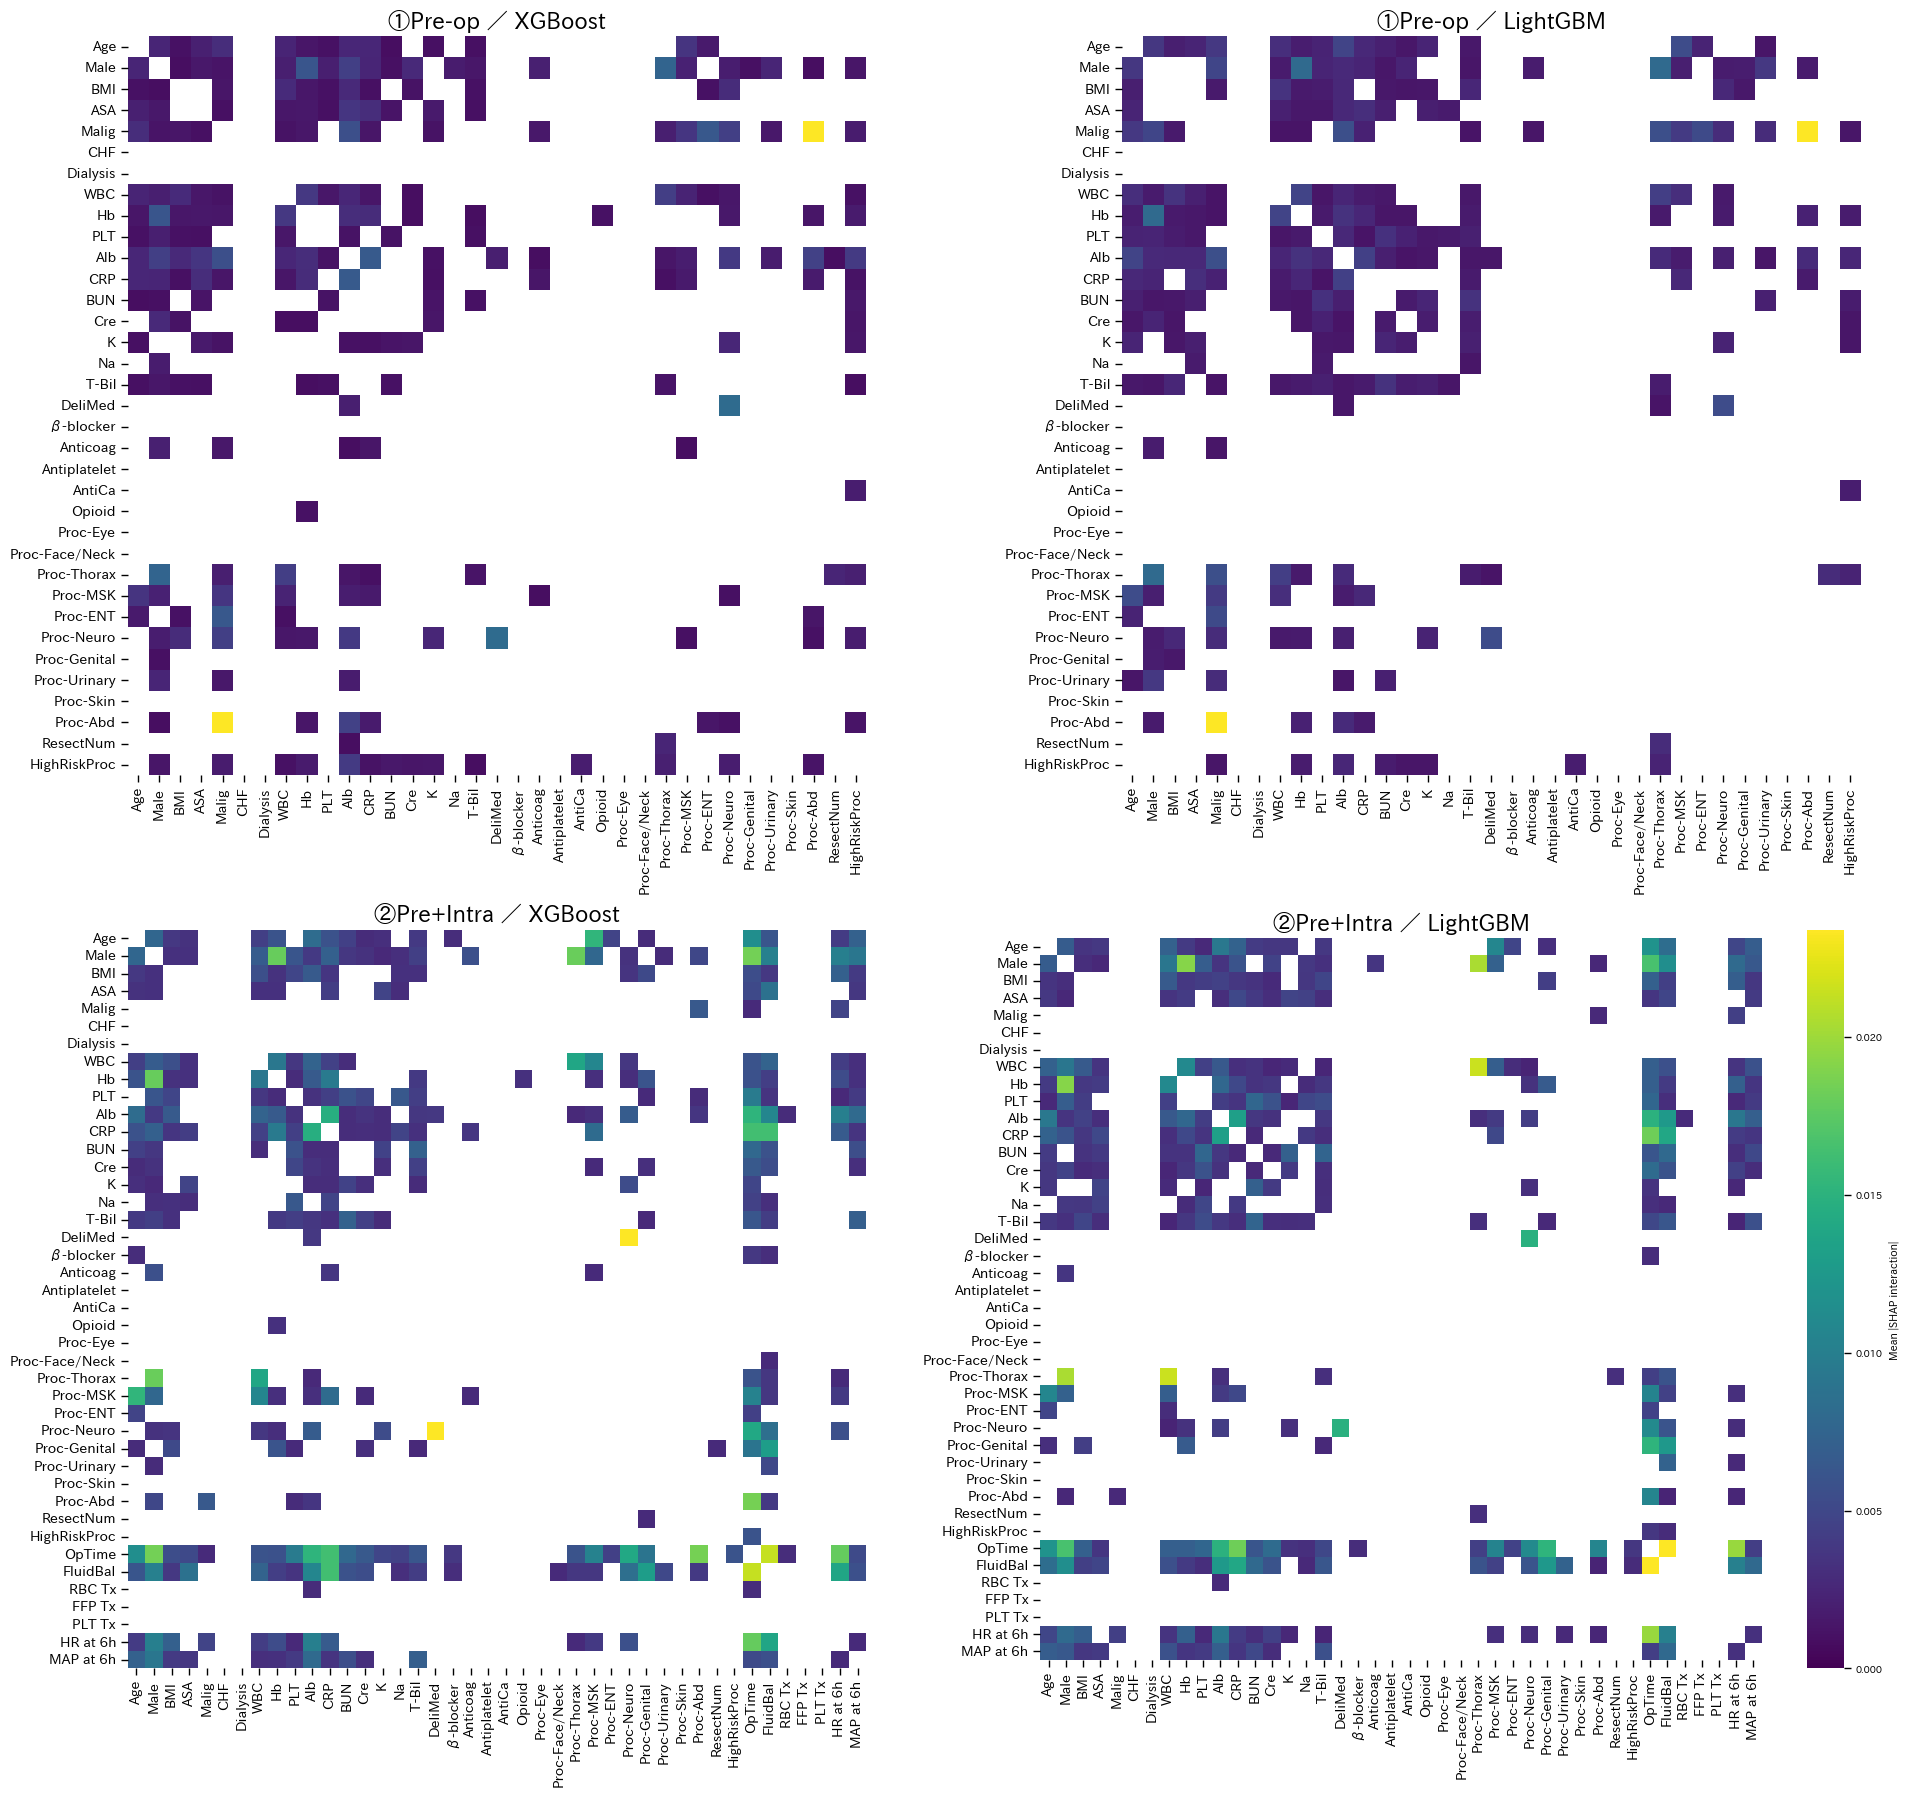

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# ① 特徴量の表示順を定義
ordered_labels = [
    # Demographics
    'Age', 'Male', 'BMI', 'ASA',
    # Comorbidities
    'Malig', 'CHF', 'Dialysis',
    # Preoperative Laboratory Data
    'WBC', 'Hb', 'PLT', 'Alb', 'CRP', 'BUN', 'Cre', 'K', 'Na', 'T-Bil',
    # Medications
    'DeliMed', 'β-blocker', 'Anticoag', 'Antiplatelet', 'AntiCa', 'Opioid','Oral steroids'
    # Surgical Procedure Categories
    'Proc-Eye', 'Proc-Face/Neck', 'Proc-Thorax', 'Proc-MSK', 'Proc-ENT',
    'Proc-Neuro', 'Proc-Genital', 'Proc-Urinary', 'Proc-Skin', 'Proc-Abd',
    'ResectNum', 'HighRiskProc',
    # Intraoperative Factors
    'OpTime', 'FluidBal', 'RBC Tx', 'FFP Tx', 'PLT Tx',
    # At 6 hours postoperatively
    'HR at 6h', 'MAP at 6h'
]

# ② モデルとバリアントの組み合わせ
combinations = [
    ("①Pre-op", "XGBoost"),
    ("①Pre-op", "LightGBM"),
    ("②Pre+Intra", "XGBoost"),
    ("②Pre+Intra", "LightGBM"),
]

# ③ グリッド準備
fig, axes = plt.subplots(2, 2, figsize=(20, 18))
axes = axes.flatten()

for ax, (variant, model_name) in zip(axes, combinations):
    # モデル読み込み＆前処理済み特徴量 df_pre の取得関数は既存のものを利用
    model, df_pre = load_model_and_df(variant, model_name)
    
    # SHAP interaction 値を計算（TreeModel のみ）
    explainer = shap.TreeExplainer(model)
    interactions = explainer.shap_interaction_values(df_pre)
    
    # 平均絶対相互作用行列を算出
    abs_int = np.abs(interactions).mean(axis=0)
    
    # DataFrame 化＆対角をゼロに
    df_int = pd.DataFrame(abs_int, index=df_pre.columns, columns=df_pre.columns)
    np.fill_diagonal(df_int.values, 0)
    
    # ordered_labels 順に並び替え
    df_int = df_int.loc[ordered_labels, ordered_labels]
    
    # 上位20％相当の閾値でマスク作成
    thresh = np.percentile(df_int.values.flatten(), 80)
    mask = df_int < thresh
    
    # ヒートマップ描画
    sns.heatmap(
        df_int, mask=mask, cmap="viridis", square=True,
        cbar=(ax is axes[-1]),      # 最後のプロットだけカラーバーを出す
        cbar_kws={"label": "Mean |SHAP interaction|"},
        ax=ax, vmin=0, vmax=df_int.values.max()
    )
    ax.set_title(f"{variant}／{model_name}", fontsize=16)
    ax.set_xticklabels(df_int.columns, rotation=90, fontsize=10)
    ax.set_yticklabels(df_int.index, rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "SHAP_Interactions_2x2.png", dpi=300)
plt.show()


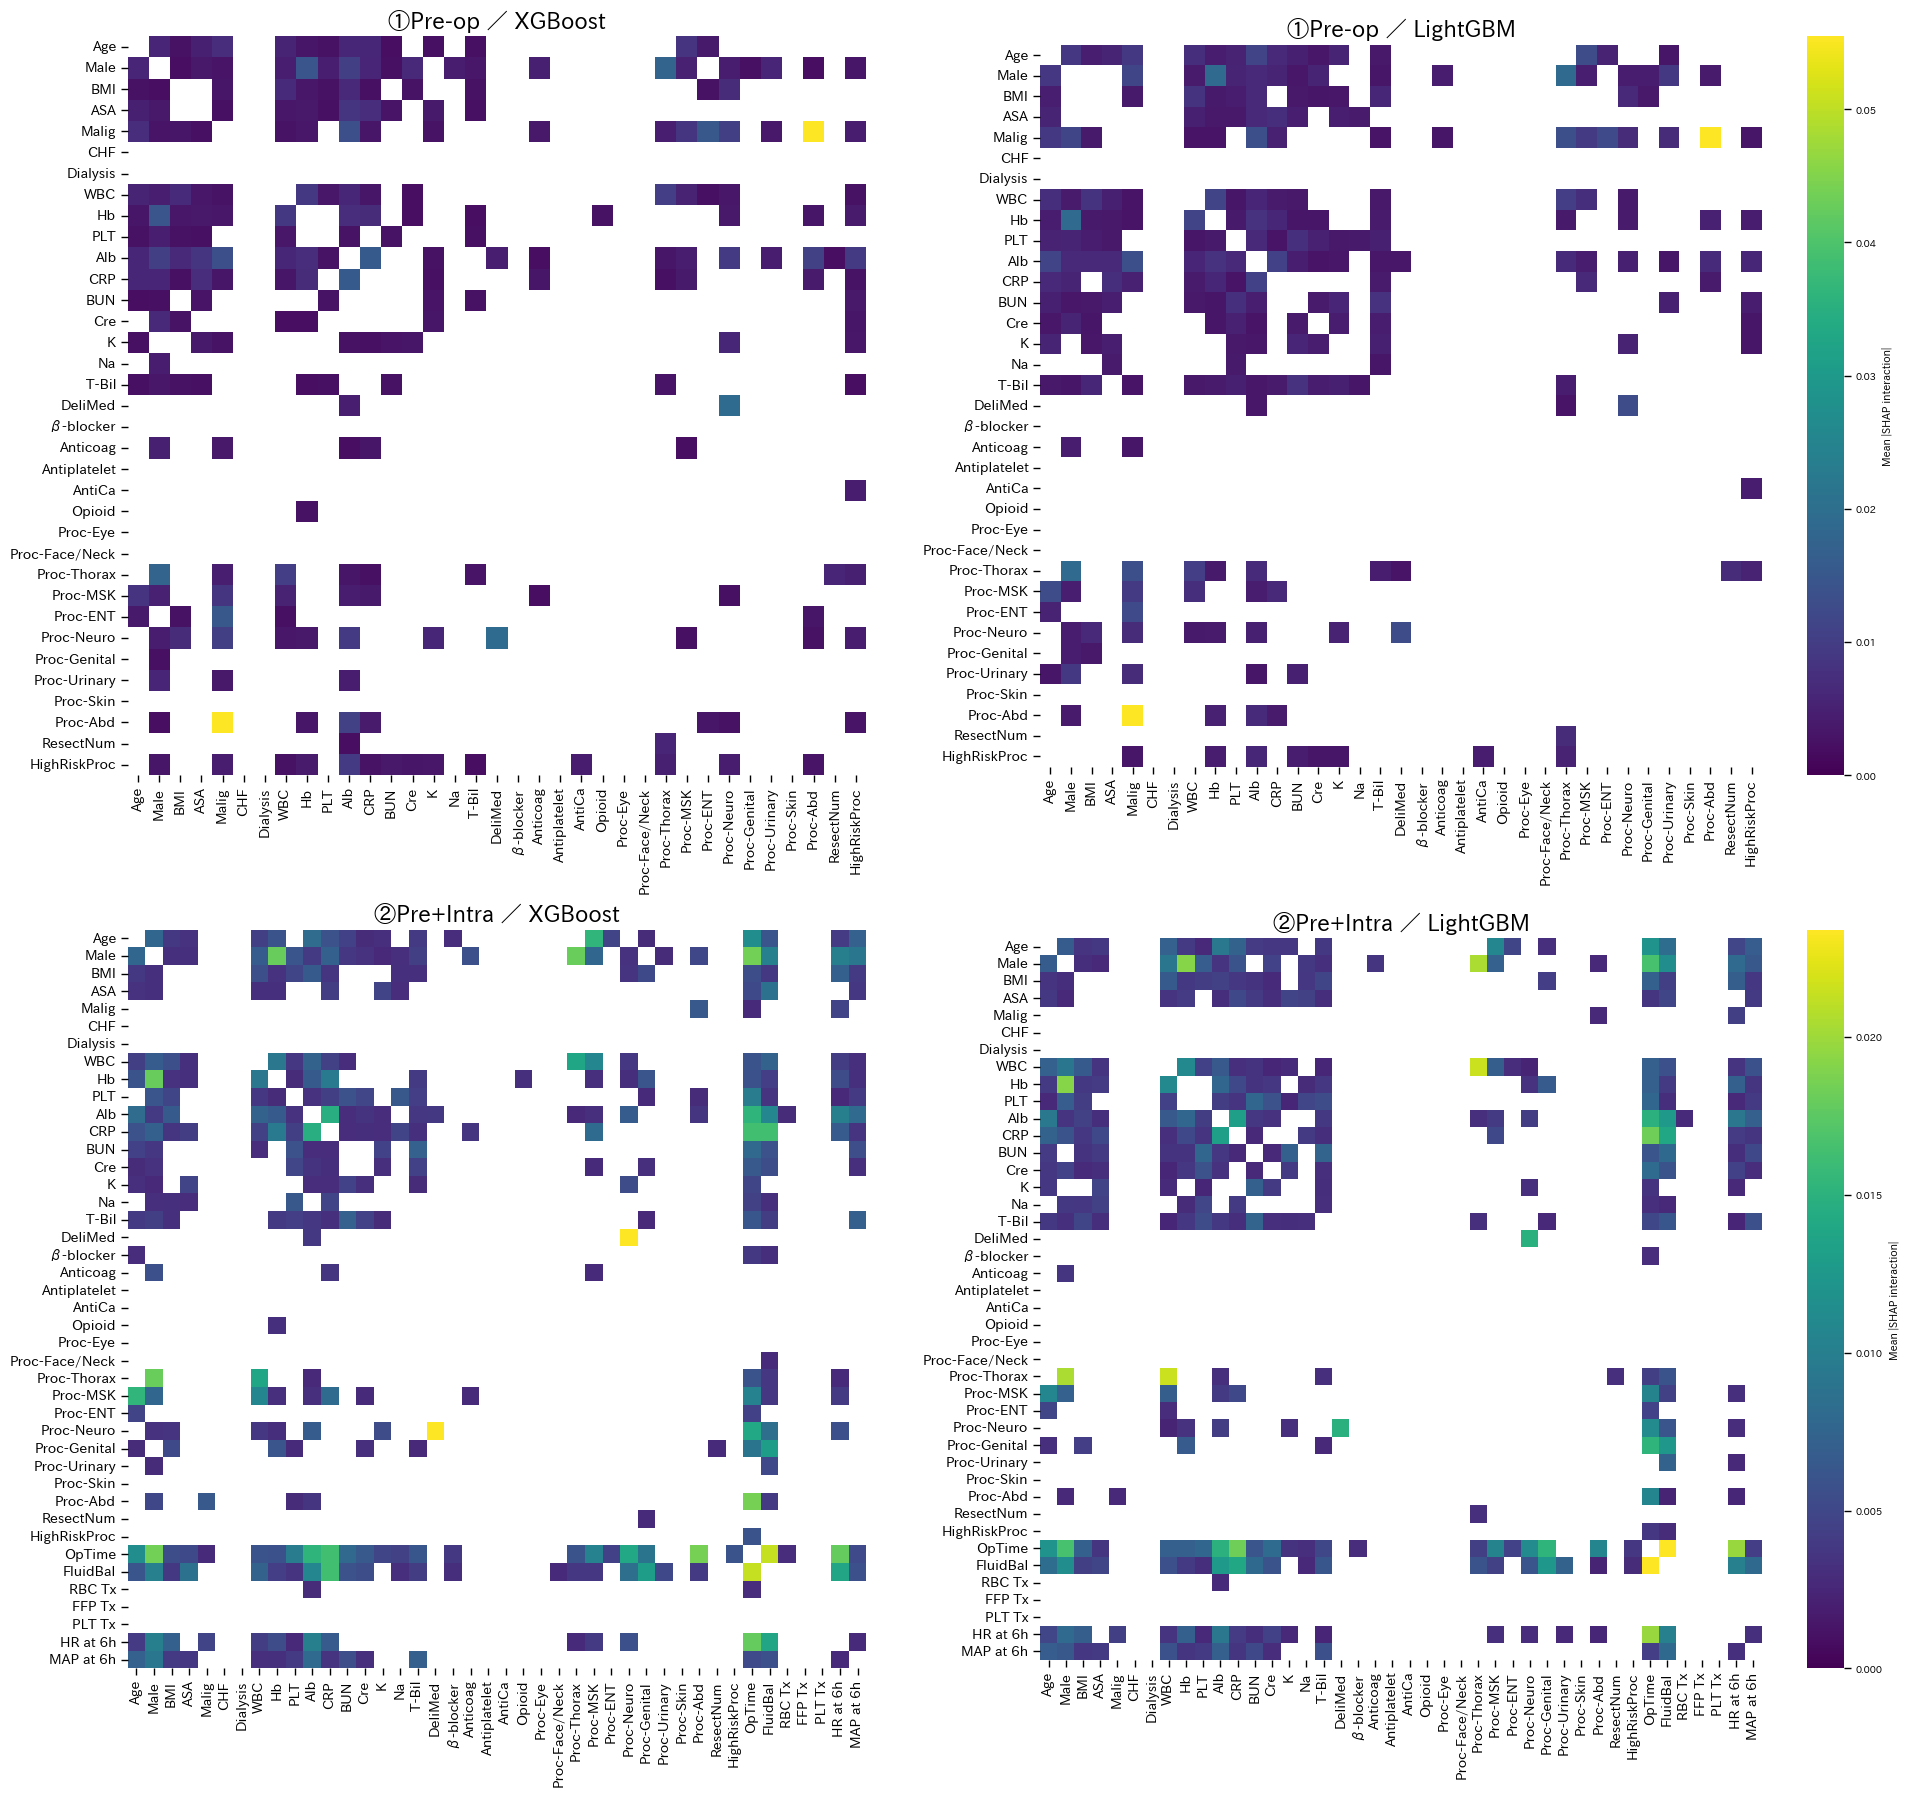

In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# (前略) load_model_and_df, ordered_labels, combinations の定義は先ほどのまま

fig, axes = plt.subplots(2, 2, figsize=(20, 18))
axes = axes.flatten()

# 全サブプロットをループ
for idx, (variant, model_name) in enumerate(combinations):
    ax = axes[idx]

    # モデル＆前処理データの読み込み
    model, df_pre = load_model_and_df(variant, model_name)

    # SHAP interaction 値
    explainer = shap.TreeExplainer(model)
    interactions = explainer.shap_interaction_values(df_pre)
    abs_int = np.abs(interactions).mean(axis=0)

    # DataFrame化＆対角を 0 に
    df_int = pd.DataFrame(abs_int, index=df_pre.columns, columns=df_pre.columns)
    np.fill_diagonal(df_int.values, 0)

    # ordered_labels と共通のラベルだけ抽出
    common = [f for f in ordered_labels if f in df_int.index]
    df_int = df_int.loc[common, common]

    # 上位20%でマスク
    thresh = np.percentile(df_int.values.flatten(), 80)
    mask = df_int < thresh

    # 2列目（idx%2==1）のときだけカラーバーを出す
    show_cbar = (idx % 2 == 1)
    sns.heatmap(
        df_int, mask=mask, cmap="viridis", square=True,
        cbar=show_cbar,
        cbar_kws={"label":"Mean |SHAP interaction|"},
        vmin=0, vmax=df_int.values.max(),
        ax=ax
    )

    ax.set_title(f"{variant} ／ {model_name}", fontsize=16)
    ax.set_xticklabels(df_int.columns, rotation=90, fontsize=10)
    ax.set_yticklabels(df_int.index, rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "SHAP_Interactions_2x2_with_bars.png", dpi=300)
plt.show()
